In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 100)

In [6]:
file_paths = {'in':'../../../data/prepared/activity_log_train.csv'
             }

df = pd.read_csv(file_paths['in'])

# guarantee the timestamps are datetime objects
time_columns = ['start_time','end_time']

for time_col in time_columns:
    df[time_col] = pd.to_datetime(df[time_col])

In [7]:
df.head()

,start_time,ride_id,row_count,segment_count,end_time,elapsed_time,moving_time,elapsed_distance,elapsed_ascent,elapsed_descent,max_speed,avg_speed,ride_cruise_speed,avg_power,ride_avg_power,ride_max_power,peak_20min_power,training_window_id,perceived_exertion,simple_exertion,perceived_relative_effort,ride_work,hours_since_last_ride,active_time_ratio,ftp_power,intensity,time_intensity,start_TOD,start_DOW
0,2020-09-02 21:21:17+00:00,4003175803,4224,15,2020-09-02 22:46:42+00:00,5151,4173,14.666919,611.2503,612.5627,28.632832,12.522739,14.541428,95.573578,112.724170,1058.440085,146.082425,4,5.0,NORMAL,75.0,580.642200,75.300833,0.810134,146.082425,0.771648,46.488211,21,2
1,2020-10-24 20:44:22+00:00,4238817655,2097,5,2020-10-24 21:22:49+00:00,2308,2058,7.747065,192.2666,146.9888,22.145705,13.312794,15.123428,103.136627,118.232006,606.592362,144.190970,5,7.0,HARD,65.0,272.879469,0.018333,0.891681,144.460600,0.818438,0.014446,20,5
2,2021-09-20 11:41:28+00:00,5990296028,2013,4,2021-09-20 12:17:01+00:00,2134,1985,7.445936,201.7815,148.6293,25.053728,13.363364,15.723231,113.923630,129.781023,1067.198334,136.550865,11,8.0,HARD,85.0,276.952703,59.486389,0.930178,169.020795,0.767841,35.729477,11,0
3,2020-10-16 19:04:26+00:00,4203579387,3169,8,2020-10-16 20:06:37+00:00,3786,3114,11.225301,318.9132,320.8818,20.579848,12.767843,14.524287,98.027222,104.373331,522.192986,128.441399,5,7.0,HARD,99.0,395.157430,459.581944,0.822504,144.460600,0.722504,292.237704,19,4
4,2020-08-06 22:28:05+00:00,3875911617,1159,11,2020-08-06 23:46:19+00:00,4720,1141,3.171579,78.4159,58.0737,29.751302,9.914663,15.002448,110.379005,94.070193,615.164105,NaN,3,5.0,NORMAL,20.0,444.011312,4.995833,0.241737,161.323024,0.583117,3.202162,22,3


In [8]:
df.shape

(126, 29)

# 1. Feature Selection

In [9]:
df.columns

Index(['start_time', 'ride_id', 'row_count', 'segment_count', 'end_time',
       'elapsed_time', 'moving_time', 'elapsed_distance', 'elapsed_ascent',
       'elapsed_descent', 'max_speed', 'avg_speed', 'ride_cruise_speed',
       'avg_power', 'ride_avg_power', 'ride_max_power', 'peak_20min_power',
       'training_window_id', 'perceived_exertion', 'simple_exertion',
       'perceived_relative_effort', 'ride_work', 'hours_since_last_ride',
       'active_time_ratio', 'ftp_power', 'intensity', 'time_intensity',
       'start_TOD', 'start_DOW'],
      dtype='object')

In [10]:
numerical_columns = ['row_count', 'segment_count','elapsed_time','moving_time', 'active_time_ratio',
                     'elapsed_distance','elapsed_ascent','elapsed_descent','max_speed','avg_speed',
                     'ride_cruise_speed','avg_power','ride_avg_power','peak_20min_power','ride_work',
                     'hours_since_last_ride','intensity','time_intensity']
categorical_columns = ['start_TOD', 'start_DOW','training_window_id']
target_column = ['simple_exertion']

### Numerical Features

In [11]:
from sklearn.feature_selection import f_classif

def perform_anova_test(X,y):
    result = f_classif(X,y)
    score = result[0][0]
    p_value = result[1][0]
    return score, p_value

def evaluate_numerical_features(df, p_threshold=0.05):
    data = df.drop('simple_exertion', axis=1)
    targets = df['simple_exertion']
    
    # create the anova results dataframe
    anova_results = pd.DataFrame(np.zeros([len(data.columns),2]),
                                index=list(data), columns=['anova_f_score','p_value'])
    
    for feature in list(data):
        # find the instances for which this feature is NaN
        filt_nan = data.loc[:,feature].isna()
        #define the existing data's X and y for sklearn
        X_feature, y_feature = data.loc[~filt_nan, feature].values, targets.loc[~filt_nan].values
        X_feature = X_feature.reshape(-1,1)
        # store the test results
        score, p_value = perform_anova_test(X_feature, y_feature)
        anova_results.loc[feature, 'anova_f_score'] = score
        anova_results.loc[feature, 'p_value'] = p_value
        
    anova_results.sort_values(by='anova_f_score', ascending=False, inplace=True)
    filt_p_value = anova_results.loc[:, 'p_value'] <= p_threshold
    
    best_features = list(anova_results.loc[filt_p_value, :].index)
    
    return anova_results, best_features
        

In [12]:
results, best_features_num = evaluate_numerical_features(df[numerical_columns+target_column])

In [13]:
results

,anova_f_score,p_value
elapsed_distance,11.943107,0.000018
ride_work,9.236968,0.000183
moving_time,8.292580,0.000418
row_count,8.218895,0.000446
avg_speed,7.911778,0.000586
elapsed_ascent,6.751688,0.001651
elapsed_descent,6.540173,0.001999
peak_20min_power,5.956570,0.003586
ride_avg_power,4.696023,0.010831
ride_cruise_speed,4.571222,0.012164


In [14]:
best_features_num

['elapsed_distance',
 'ride_work',
 'moving_time',
 'row_count',
 'avg_speed',
 'elapsed_ascent',
 'elapsed_descent',
 'peak_20min_power',
 'ride_avg_power',
 'ride_cruise_speed',
 'elapsed_time',
 'intensity']

### Categorical Features

In [15]:
from sklearn.feature_selection import chi2

def perform_chi2_test(X,y):
    result = chi2(X,y)
    score = result[0][0]
    p_value = result[1][0]
    return score, p_value

def evaluate_categorical_features(df, p_threshold=0.05):
    data = df.drop('simple_exertion', axis=1)
    targets = df['simple_exertion']
    
    # create the anova results dataframe
    chi2_results = pd.DataFrame(np.zeros([len(data.columns),2]),
                                index=list(data), columns=['chi2_score','p_value'])
    
    for feature in list(data):
        # find the instances for which this feature is NaN
        filt_nan = data.loc[:,feature].isna()
        #define the existing data's X and y for sklearn
        X_feature, y_feature = data.loc[~filt_nan, feature].values, targets.loc[~filt_nan].values
        X_feature = X_feature.reshape(-1,1)
        # store the test results
        score, p_value = perform_chi2_test(X_feature, y_feature)
        chi2_results.loc[feature, 'chi2_score'] = score
        chi2_results.loc[feature, 'p_value'] = p_value
        
    chi2_results.sort_values(by='chi2_score', ascending=False, inplace=True)
    filt_p_value = chi2_results.loc[:, 'p_value'] <= p_threshold
    
    best_features = list(chi2_results.loc[filt_p_value, :].index)
    
    return chi2_results, best_features
        

In [16]:
results, best_features_cat = evaluate_categorical_features(df[categorical_columns+target_column])

In [17]:
results

,chi2_score,p_value
training_window_id,11.614369,0.003006
start_DOW,3.830920,0.147274
start_TOD,0.074279,0.963542


## Saving the Selected Features

In [18]:
selected_features = best_features_num + best_features_cat + target_column
print(selected_features)

['elapsed_distance', 'ride_work', 'moving_time', 'row_count', 'avg_speed', 'elapsed_ascent', 'elapsed_descent', 'peak_20min_power', 'ride_avg_power', 'ride_cruise_speed', 'elapsed_time', 'intensity', 'training_window_id', 'simple_exertion']


In [19]:
df[selected_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   elapsed_distance    126 non-null    float64
 1   ride_work           126 non-null    float64
 2   moving_time         126 non-null    int64  
 3   row_count           126 non-null    int64  
 4   avg_speed           126 non-null    float64
 5   elapsed_ascent      126 non-null    float64
 6   elapsed_descent     126 non-null    float64
 7   peak_20min_power    104 non-null    float64
 8   ride_avg_power      126 non-null    float64
 9   ride_cruise_speed   126 non-null    float64
 10  elapsed_time        126 non-null    int64  
 11  intensity           126 non-null    float64
 12  training_window_id  126 non-null    int64  
 13  simple_exertion     126 non-null    object 
dtypes: float64(9), int64(4), object(1)
memory usage: 13.9+ KB


In [20]:
# Need to fill in the missing values for peak_20min_power.
# Use intensity * FTP to estimate the missing
filt_nan = df['peak_20min_power'].isna()

df.loc[filt_nan, 'peak_20min_power'] = df.loc[filt_nan,'ftp_power'] * df.loc[filt_nan, 'intensity']

# Numerical Trend Confirmation

In [21]:
def plot_ecdf_comparison(df, num_column, plotsize=(10,6), xlimits=None):
    fig = plt.figure(figsize=plotsize)

    _ = sns.ecdfplot(data=df, x=num_column, hue='simple_exertion', linewidth=2.5)
    _ = plt.grid()
    if xlimits is not None:
        _ = plt.xlim(xlimits)

In [22]:
print(best_features_num)

['elapsed_distance', 'ride_work', 'moving_time', 'row_count', 'avg_speed', 'elapsed_ascent', 'elapsed_descent', 'peak_20min_power', 'ride_avg_power', 'ride_cruise_speed', 'elapsed_time', 'intensity']


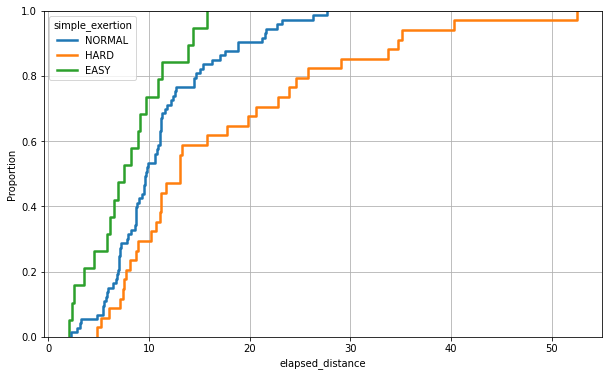

In [23]:
plot_ecdf_comparison(df, 'elapsed_distance')

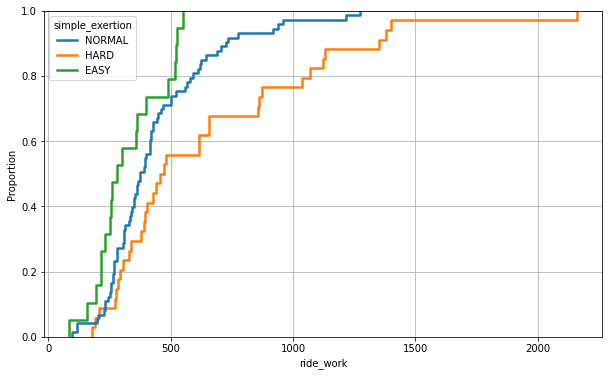

In [24]:
plot_ecdf_comparison(df, 'ride_work')

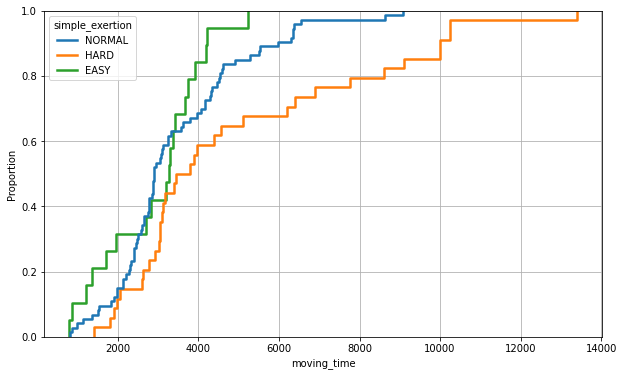

In [25]:
plot_ecdf_comparison(df, 'moving_time')

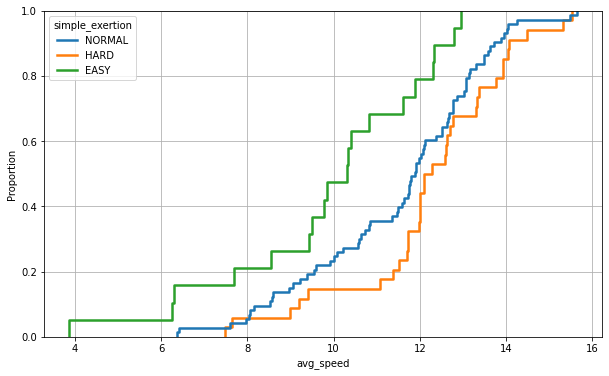

In [26]:
plot_ecdf_comparison(df, 'avg_speed')

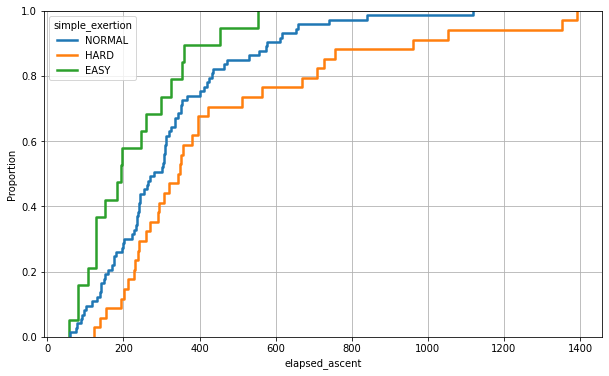

In [27]:
plot_ecdf_comparison(df, 'elapsed_ascent')

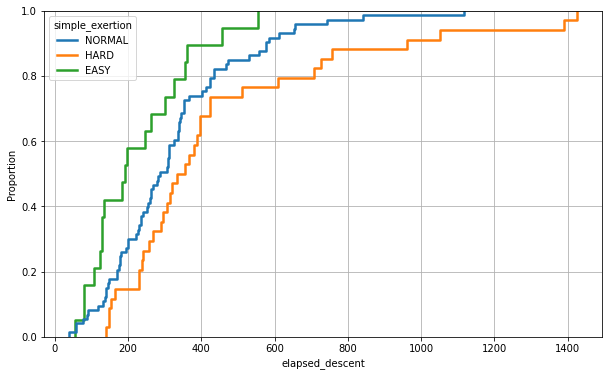

In [28]:
plot_ecdf_comparison(df, 'elapsed_descent')

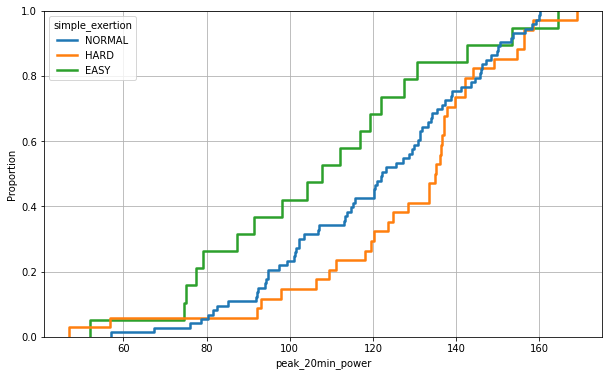

In [29]:
plot_ecdf_comparison(df, 'peak_20min_power')

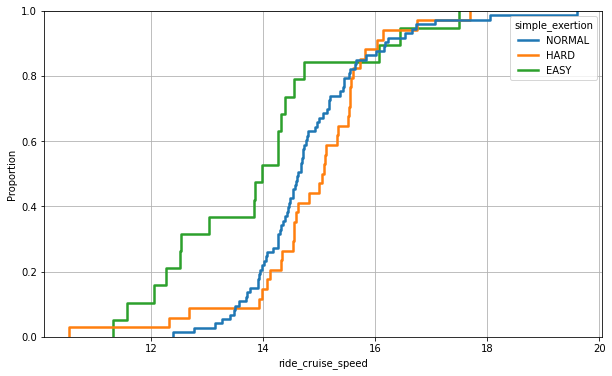

In [30]:
plot_ecdf_comparison(df, 'ride_cruise_speed')

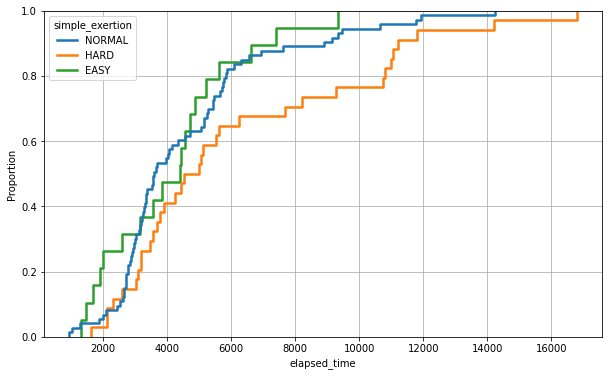

In [31]:
plot_ecdf_comparison(df, 'elapsed_time')

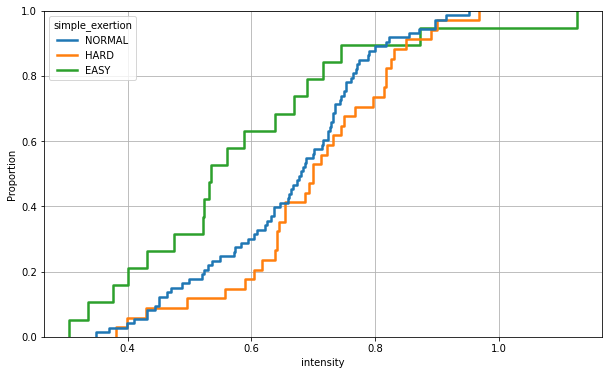

In [32]:
plot_ecdf_comparison(df, 'intensity')

# Categorical Trend Confirmation

In [33]:
def plot_bar_comparison(df, cat_column, plotsize=(10,6)):
    fig = plt.figure(figsize=plotsize)

    _ = sns.barplot(data=df, y=cat_column, x='simple_exertion')
    _ = plt.grid()

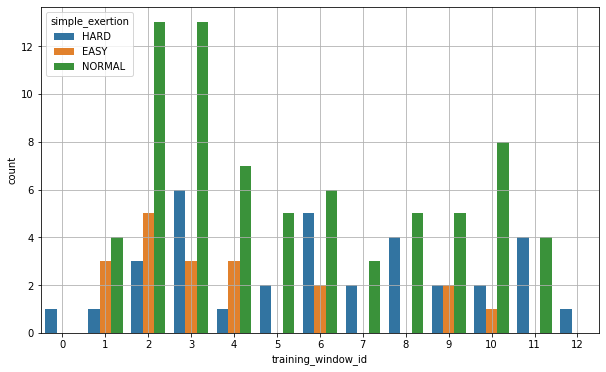

In [34]:
bar_groups = ['training_window_id','simple_exertion']
df_bar = df[bar_groups+['ride_id']].groupby(bar_groups).count().reset_index().rename(columns={'ride_id':'count'})

plotsize=(10,6)
fig = plt.figure(figsize=plotsize)
_ = sns.barplot(data=df_bar, x='training_window_id', y='count', hue='simple_exertion')
_ = plt.grid()

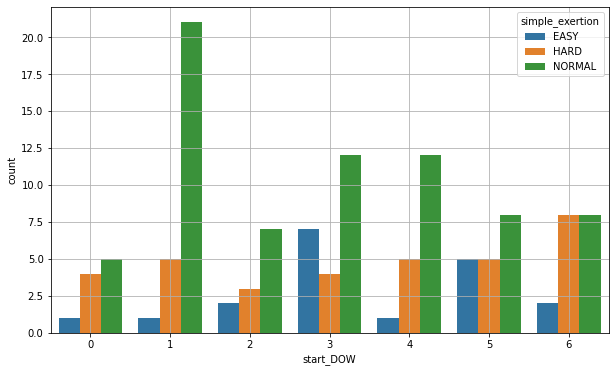

In [35]:
bar_groups = ['start_DOW','simple_exertion']
df_bar = df[bar_groups+['ride_id']].groupby(bar_groups).count().reset_index().rename(columns={'ride_id':'count'})

plotsize=(10,6)
fig = plt.figure(figsize=plotsize)
_ = sns.barplot(data=df_bar, x='start_DOW', y='count', hue='simple_exertion')
_ = plt.grid()

# Correlations & Collinearity

In [36]:
df = df[selected_features]

In [37]:
df_corr = df.corr()

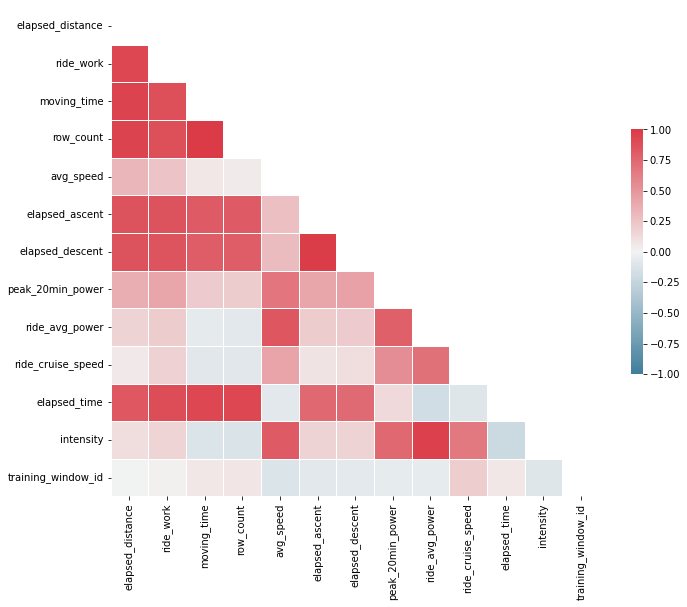

In [38]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(df_corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Observations**:
- `elapsed_time` is highly correlated with `moving_time`, `elapsed_distance`, `ride_work`, `row_count`
    - it is also closely related to `elapsed_ascent` and `elapsed_descent` 
    - This makes sense because all of these columns have very similar CDF distributions. Also because a longer trip will naturally increase all of these
    - **KEEP**: `elapsed_distance` because this is the best separation
    - **KEEP**: `moving_time` because of the slight negative correlations
- `peak_20min_power` is pretty well separated from other columns except for `intensity` (makes sense) and `ride_avg_power` since a ride with higher peak power will also raise the average power.
    - **KEEP**: `peak_20min_power`, `ride_avg_power` 
    - **DROP**: `intensity` since it wasn't as helpful in the ANOVA
- The Speed columns seem overall pretty useful. Keep both of them

In [39]:
cols_to_keep = ['simple_exertion','elapsed_distance','moving_time','avg_speed','ride_cruise_speed','ride_avg_power',
                'peak_20min_power', 'training_window_id']

In [40]:
df_corr = df[cols_to_keep].corr()

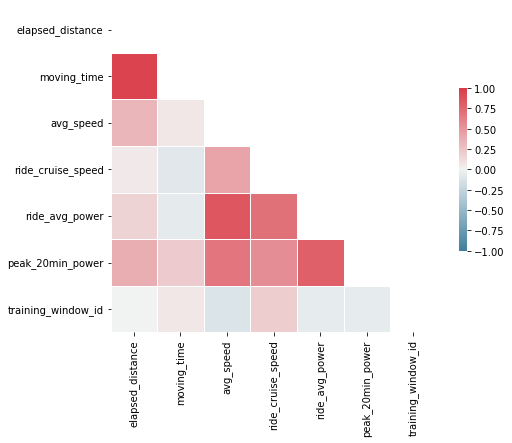

In [41]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(df_corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# SAVE

In [42]:
#df.to_csv(file_paths['out'], index=False)

# Don't actually save this... I need to use a pipeline to select the columns I want